In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string  
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC



#### Load the dataset

In [4]:
tt = pd.read_csv("C:\\Users\\user\\Desktop\\twitter_training.csv",encoding='latin1')
tt


2401  Borderlands  Positive  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   
...     ...          ...       ...   
74676  9200       Nvidia  Positive   
74677  9200       Nvidia  Positive   
74678  9200       Nvidia  Positive   
74679  9200       Nvidia  Positive   
74680  9200       Nvidia  Positive   

                                                       a  
0      I am coming to the borders and I will kill you...  
1      im getting on borderlands and i will kill you ...  
2      im coming on borderlands and i will murder you...  
3      im getting on borderlands 2 and i will murder ...  
4      im getting into borderlands and i can murder y...  
...                                                  ...  
74676  Just realized that the Windows partition of my...  
74677  Just realized that my Mac window partition is ...  
74678  Just realized the windows partition of my Mac ...  
74679  Just realized between the windows partition of...  
74680  Just like the windows partition of my Mac is l...  

[74681 rows x 4 columns]

This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

2401 ->The user's ID 

Borderlands->Entity

Positive->The sentiment associated with the tweet

a->Tweet content

Detecting missing values is a vital aspect of data analysis as it enables the identification of incomplete or unavailable information within a dataset. This knowledge plays a crucial role in guiding subsequent data cleaning, imputation, or analysis processes, ensuring the data's integrity and reliability.

In [16]:
tt.isnull().sum()

2401             0
Borderlands      0
Positive         0
a              686
dtype: int64

Then we check for missing or empty values in each column of the "tt" dataset and then calculate the sum of missing values for each column. The resulting output shows the number of missing values in each column:

The column titled "a" has 686 instances of missing values. This indicates that there are 686 rows in the dataset where no location information is recorded. However, the remaining columns in the dataset are complete and do not contain any missing values.

To gain a clear understanding of the chosen database, we can utilize certain functions to determine the size of the DataFrame "HDI":

In [17]:
tt.shape

(74681, 4)

In [18]:
tt.describe

<bound method NDFrame.describe of        2401  Borderlands  Positive  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   
...     ...          ...       ...   
74676  9200       Nvidia  Positive   
74677  9200       Nvidia  Positive   
74678  9200       Nvidia  Positive   
74679  9200       Nvidia  Positive   
74680  9200       Nvidia  Positive   

                                                       a  
0      I am coming to the borders and I will kill you...  
1      im getting on borderlands and i will kill you ...  
2      im coming on borderlands and i will murder you...  
3      im getting on borderlands 2 and i will murder ...  
4      im getting into borderlands and i can murder y...  
...                                                  ...  
74676  Just realized that the Windows partition of my...  
74677  Just realized that my Mac wind

Let's ensure that the column names in the "tt" dataset are cleaned and properly formatted by removing any leading or trailing white spaces. This will result in column names that are free from any extra spaces and appropriately formatted.

In [19]:
# Striping the column names
tt.columns = tt.columns.str.strip()

### What are the most common sentiments expressed in the tweets?

Most Common Sentiments:
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: Positive, dtype: int64


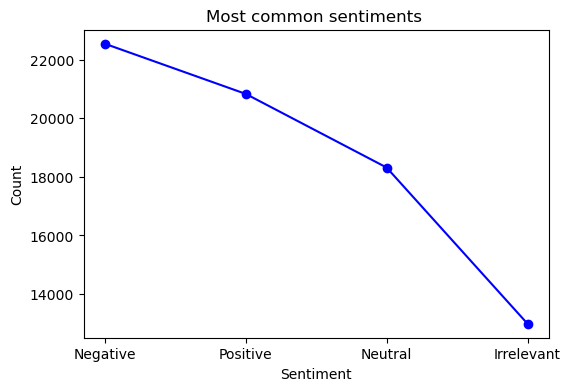

In [20]:
# Count the occurrences of each sentiment
sentiment_counts = tt['Positive'].value_counts()

# Display the most common sentiments
print("Most Common Sentiments:")
print(sentiment_counts)
# Create a DataFrame from sentiment_counts
sentiment_df = pd.DataFrame({'Positive': sentiment_counts.index, 'Count': sentiment_counts.values})
# Create a line graph
plt.figure(figsize=(6, 4))
plt.plot(sentiment_df['Positive'], sentiment_df['Count'], marker='o', linestyle='-', color='blue')
plt.title('Most common sentiments ')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Display the line graph
plt.show()


The line graph represents the distribution of the most common sentiments in the dataset.

In this specific case, the sentiment categories are "Negative," "Positive," "Neutral," and "Irrelevant." The count of occurrences for each sentiment is provided next to the sentiment category.

According to the sentiment counts:

"Negative" has the highest count, with 22,542 occurrences.
"Positive" follows closely behind with 20,831 occurrences.
"Neutral" has a count of 18,318 occurrences.
"Irrelevant" has the lowest count, with 12,990 occurrences.
The line graph visually represents these sentiment counts. Each sentiment category is marked on the x-axis, and the corresponding count is represented by a point on the y-axis. The points are then connected by a line to illustrate the overall trend.

### Most commonly used words in postive review


In [19]:
# Define the text preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Remove numbers
    text = re.sub(r'\d', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)    #######applying appropriate preprocessing steps
    return text

# Apply text preprocessing to the 'a' column and create a new 'processed_text' column
tt['processed_text'] = tt['a'].astype(str).apply(lambda x: preprocess_text(x))


# Combine all preprocessed positive reviews into a single string
text = ' '.join(tt['processed_text'])

# Split the text into individual words
words = text.split()
# Calculate the word frequencies
word_counts = Counter(words)

# Get the most common words and their frequencies
top_words = word_counts.most_common(25)
# Display the most common words and their frequencies
for word, count in top_words:
    print(f"Word: {word}, Frequency: {count}")



Word: the, Frequency: 44275
Word: i, Frequency: 29222
Word: to, Frequency: 28809
Word: and, Frequency: 26568
Word: a, Frequency: 24121
Word: of, Frequency: 19251
Word: is, Frequency: 17806
Word: for, Frequency: 15586
Word: in, Frequency: 15390
Word: this, Frequency: 14646
Word: it, Frequency: 13771
Word: you, Frequency: 12151
Word: on, Frequency: 12050
Word: my, Frequency: 11835
Word: that, Frequency: 10227
Word: with, Frequency: 8857
Word: game, Frequency: 8055
Word: so, Frequency: 7794
Word: me, Frequency: 6988
Word: have, Frequency: 6682
Word: just, Frequency: 6657
Word: but, Frequency: 6345
Word: not, Frequency: 6309
Word: are, Frequency: 6049
Word: be, Frequency: 6034


The result represent the most common words in the dataset, along with their corresponding frequencies. Here's an explanation of the conclusion:

The word "the" appears most frequently, with a frequency count of 44,275. This suggests that "the" is a highly common word in the text.

Other frequently occurring words include "i" with a count of 29,222, "to" with 28,809, and "and" with 26,568. These words are commonly used in the text.

The words "a" (24,121) and "of" (19,251) also have high frequencies, indicating their frequent usage in the text.

Furthermore, words such as "is" (17,806), "for" (15,586), "in" (15,390), and "this" (14,646) are among the common words in the dataset.

The presence of words like "game" (8,055) suggests that the text may contain references or discussions related to games.

In [21]:
!pip install wordcloud


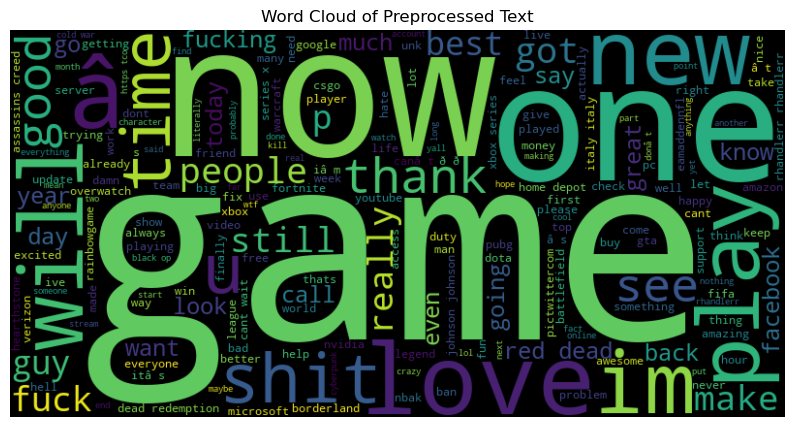

In [22]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Preprocessed Text')
plt.axis('off')

plt.show()

The code generates a word cloud visualization based on the preprocessed text from the 'a' column.The word cloud represents the frequency of words in the preprocessed text. Words that appear more frequently are displayed in larger font sizes(e.g. game,now,one), while less frequent words are smaller(make,know,call,guy...).

# Who are the 5 entities that have negative sentiment?

In [22]:
# Calculate the top 5 negative entities
negative_entities = tt.loc[tt['Positive'] == 'Negative', 'Borderlands'].value_counts().head(5)

# Print the 5 entities with negative sentiment
print("Entities with negative sentiment:")
print(negative_entities.index)


Entities with negative sentiment:
Index(['MaddenNFL', 'NBA2K', 'FIFA', 'TomClancysRainbowSix', 'Verizon'], dtype='object')


The result shows the top 5 entities with negative sentiment which are MaddenNF, NBA2K, FIFA, TomClancysRainbowSix and Verizon.

# How does the sentiment distribution vary across different entinties?

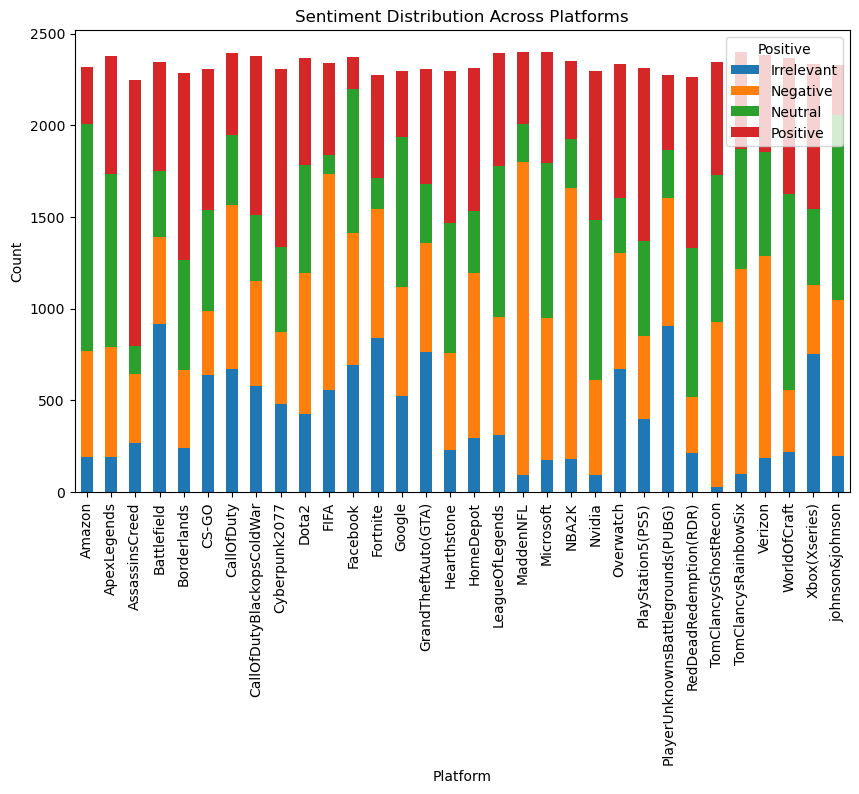

In [23]:
# Filter the dataset for the 'Borderlands' variable and 'sentiment' variable
tt = tt[['Borderlands', 'Positive']]

# Group the data by 'Borderlands' and 'sentiment' and count the occurrences
sentiment_counts = tt.groupby(['Borderlands', 'Positive']).size().unstack()
sentiment_counts
# Plot the sentiment distribution for each platform
sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set the plot labels and title
plt.xlabel('Platform')
plt.ylabel('Count')
plt.title('Sentiment Distribution Across Platforms')

# Display the plot
plt.show()



The bar plot displays the sentiment distribution across different platforms for the 'Borderlands'(entity) variable. Each bar represents a platform, and the height of the bar represents the count of tweets for each sentiment category (positive, negative, neutral, irrelevant) associated with that platform. 

Let's take an example to understand the graph. Consider the platform "Amazon." The stacked bar for Amazon consists of four segments representing the sentiments: Positive, Irrelevant, Negative, and Neutral. The heights of the segments indicate the count of each sentiment category.
We can see that for Amazon, there are 192 occurrences of Positive sentiment, 576 occurrences of Irrelevant sentiment, 1236 occurrences of Negative sentiment, and 312 occurrences of Neutral sentiment.

Similarly, for other platforms such as ApexLegends, AssassinsCreed, Battlefield, and so on, the stacked bars show the distribution of sentiments specific to each platform.

# Are there any specific entities that are frequently mentioned together in tweets?

C:\Users\user\AppData\Local\Temp\ipykernel_11212\2300100775.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_entities.loc['Other'] = other_count


Nvidia: 100.0%
Other: 0.0%


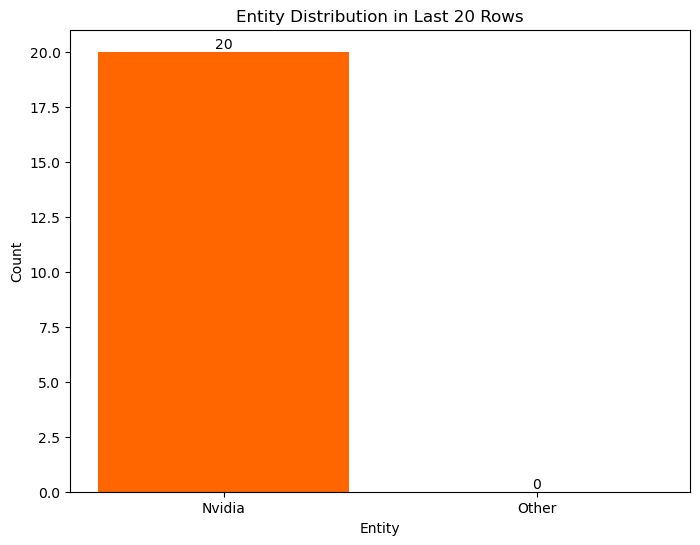

In [15]:
# Get the last 20 rows of the dataset
last_20_rows = tt.tail(20)

# Create a dictionary to store the entity co-occurrence counts
entity_counts = {}

# Iterate through each tweet in the last 20 rows
for entities in last_20_rows['Borderlands']:
    # Split the entities into a list
    entities_list = entities.split(',')

    # Remove leading/trailing whitespaces from entities
    entities_list = [entity.strip() for entity in entities_list]

    # Update the entity counts
    for entity in entities_list:
        if entity in entity_counts:
            entity_counts[entity] += 1
        else:
            entity_counts[entity] = 1

# Convert the entity counts to a DataFrame
tt_entity_counts = pd.DataFrame.from_dict(entity_counts, orient='index', columns=['Count'])

# Sort the entities by count in descending order
tt_entity_counts = tt_entity_counts.sort_values(by='Count', ascending=False)

# Keep the top 10 entities and combine the rest into 'Other' category
top_n = 10  # Specify the number of top entities to include
top_entities = tt_entity_counts.head(top_n)
other_count = tt_entity_counts[top_n:].sum()
top_entities.loc['Other'] = other_count

# Display the entity labels with percentages
show_labels = True  # Set to False if we don't want to display the labels
if show_labels:
    total_count = top_entities['Count'].sum()
    for entity, count in top_entities.iterrows():
        percentage = count['Count'] / total_count * 100
        print(f"{entity}: {percentage:.1f}%")
# Calculate the counts for Nvidia and Other entities
nvidia_count = last_20_rows['Borderlands'].str.contains('Nvidia').sum()
other_count = len(last_20_rows) - nvidia_count

# Create the data for the bar chart
labels = ['Nvidia', 'Other']
counts = [nvidia_count, other_count]
colors = ['#FF6600', '#0099CC']

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=colors)

# Add data labels to the bars
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Add a title and labels
plt.title('Entity Distribution in Last 20 Rows')
plt.xlabel('Entity')
plt.ylabel('Count')

# Display the chart
plt.show()


The result shows that in the last 20 rows of the dataset, the entity "Nvidia" appears in all of them, accounting for 100% of the occurrences. The "Other" category represents the combined count of all other entities that were present in those rows, and in this case, it has a count of 0, indicating that no other entities were present besides "Nvidia".

### What are the main topics and their corresponding top words  about Twitter? (LDA model) ?

Now that we have our text preprocessed, let's start with our first topic modelling algorithm: Latent Dirichlet Allocation (LDA). LDA assumes that every document is a mixture of topics and that every word in the document is attributable to the document's topics.

We'll use the LDA implementation from the sklearn library.

In [31]:
# Replace missing values with an empty string
tt['a'] = tt['a'].fillna('')
# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(tt['a'])

# Create and fit LDA model
num_topics = 3  # Specify the number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X_tfidf)

# Get the topic-word distributions
topic_word_distributions = lda_model.components_

# Get the document-topic distributions
doc_topic_distributions = lda_model.transform(X_tfidf)

# Get the feature names from the TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Print the top words for each topic
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Topic #{topic_idx+1}:")
    print(", ".join(top_words))
    print()

Topic #1:
the, of, you, in, my, is, this, to, wow, and

Topic #2:
the, to, it, and, is, this, of, that, game, for

Topic #3:
com, the, johnson, unk, to, for, in, of, player, ban



The output  shows the top words for each of the 3 topics generated by the LDA model.
The argsort() function from numpy gets the indices that would sort the topic array. It returns the indices that would sort an array.

LDA, as an unsupervised learning algorithm for topic modeling, allows us to discover hidden topics without prior knowledge or supervision. It is particularly advantageous for exploring large collections of text data, such as the Twitter dataset, as it can identify underlying themes and discussions related to sentiment analysis on Twitter. By modeling multiple topics, LDA provides a comprehensive analysis of the tweet content, allowing us to gain a nuanced understanding of the topics present.
One of the key benefits of LDA is its interpretability. By examining the top words associated with each topic, we can gain insights into the main themes and discussions within the dataset. This interpretability enables us to analyze and understand the sentiment patterns associated with different entities on Twitter. Additionally, LDA provides topic probabilities for each document, allowing us to explore the distribution of topics across the dataset and identify the dominant topics.

However, it's important to consider certain factors. Selecting the optimal number of topics and employing proper preprocessing techniques, such as tokenization and stop word removal, are crucial for accurate results. LDA assumes independence between documents, potentially disregarding dependencies or relationships among tweets.


By leveraging LDA on the Twitter Sentiment Analysis dataset, we gain valuable insights into topics, sentiments, and discussions related to different entities on Twitter. This combination of LDA's interpretability and the dataset's information allows us to uncover patterns and trends, making it a powerful tool for sentiment analysis.

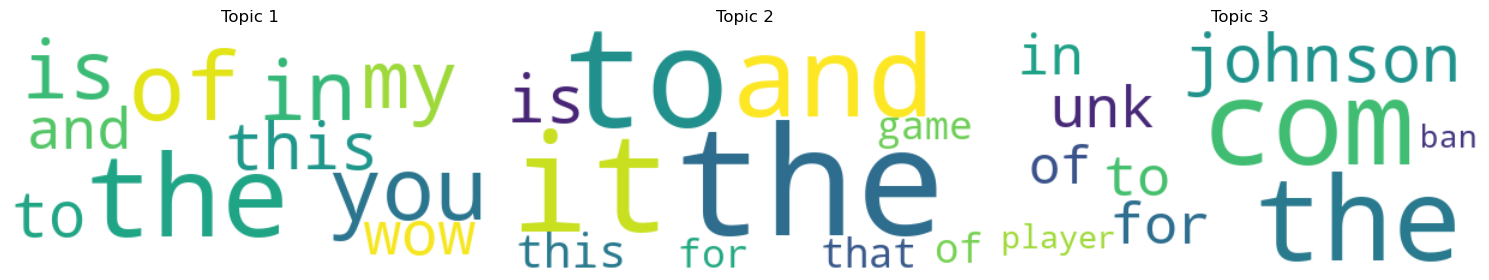

In [32]:
# Show results in a graph for the first 5 topics
num_topics_to_display = 3

fig, axes = plt.subplots(1, num_topics_to_display, figsize=(15, 5))

for i, topic in enumerate(lda_model.components_[:num_topics_to_display]):
    topic_words = {feature_names[j]: topic[j] for j in topic.argsort()[:-11:-1]}
    wc = WordCloud(background_color="white", max_words=2000)
    wc.generate_from_frequencies(topic_words)
    
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f'Topic {i+1}')

plt.tight_layout()
plt.show()

For each topic, a WordCloud visualization is created using the top 10 words associated with that topic. The size of each word in the WordCloud is determined by its frequency within the topic. The WordCloud provides a visual representation of the most important words in the topic, with larger words indicating higher frequencies.

The graph showcases the WordClouds for the 3 topics side by side. Each subplot is titled with the corresponding topic number, ranging from 1 to 3.

Topic #1: Topic related to general expressions and reactions
This topic consists of common words such as "the," "of," "you," "in," "my," "is," "this," "to," "wow," and "and." It appears to capture general expressions, reactions, and possibly conversations or observations about various subjects.

Topic #2: Topic related to gaming and entertainment
The focus of this topic seems to be on gaming and entertainment. It includes words such as "the," "to," "it," "and," "is," "this," "of," "that," "game," and "for." The topic suggests discussions or references to games, their features, and possibly opinions or experiences related to gaming.

Topic #3: Topic related to player and community interactions
This topic includes words like "com," "the," "johnson," "unk," "to," "for," "in," "of," "player," and "ban." It appears to involve discussions or references to player interactions, communities, and potentially issues related to bans or restrictions.

### What are the main topics present in a collection of  "tweet content" about a specific topic , as identified by applying Non-Negative Matrix Factorization (NMF) on TF-IDF vectors?

NMF is a dimensionality reduction and clustering algorithm that assumes that all data and components are non-negative. It's a faster and simpler alternative to LDA that can yield good results when dealing with smaller datasets.

It assumes that all data and components are non-negative. The intuition behind NMF is that it decomposes (or factorizes) the document-term matrix into two other matrices: one with dimensions number-of-documents by number-of-topics, and the other with dimensions number-of-topics by number-of-terms.

The main difference between NMF and LDA is that while LDA uses a probabilistic approach (assuming documents are generated by a probabilistic process), NMF uses a linear algebra approach. This makes NMF faster and more scalable to larger datasets, and it doesn't require tuning as many hyperparameters.

In [33]:
# Create a TfidfVectorizer with reduced vocabulary size
vectorizer = TfidfVectorizer(max_features=10000, max_df=0.95, min_df=2, stop_words='english')

# Fit and transform 
tfidf_matrix = vectorizer.fit_transform(tt['a'])

# Convert the TF-IDF matrix to a sparse CSR matrix
tfidf_matrix_sparse = csr_matrix(tfidf_matrix)

# Get the feature names (words) from the vectorizer's vocabulary
feature_names = vectorizer.get_feature_names_out()

# Create an NMF model with the desired number of topics
num_topics = 3
nmf_model = NMF(n_components=num_topics, random_state=42)

# Fit the NMF model to the sparse TF-IDF matrix
nmf_model.fit(tfidf_matrix_sparse)

# Print the top words for each topic
for idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(f"Topic {idx}: {' '.join(top_words)}")

# Convert the TF-IDF matrix to a DataFrame 
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)


Topic 0: com pic twitter rhandlerr player ban facebook bf4db battlefield details
Topic 1: game just love good like shit play really fuck dead
Topic 2: unk com wow johnson happy wtf playstation verizon youtu thank


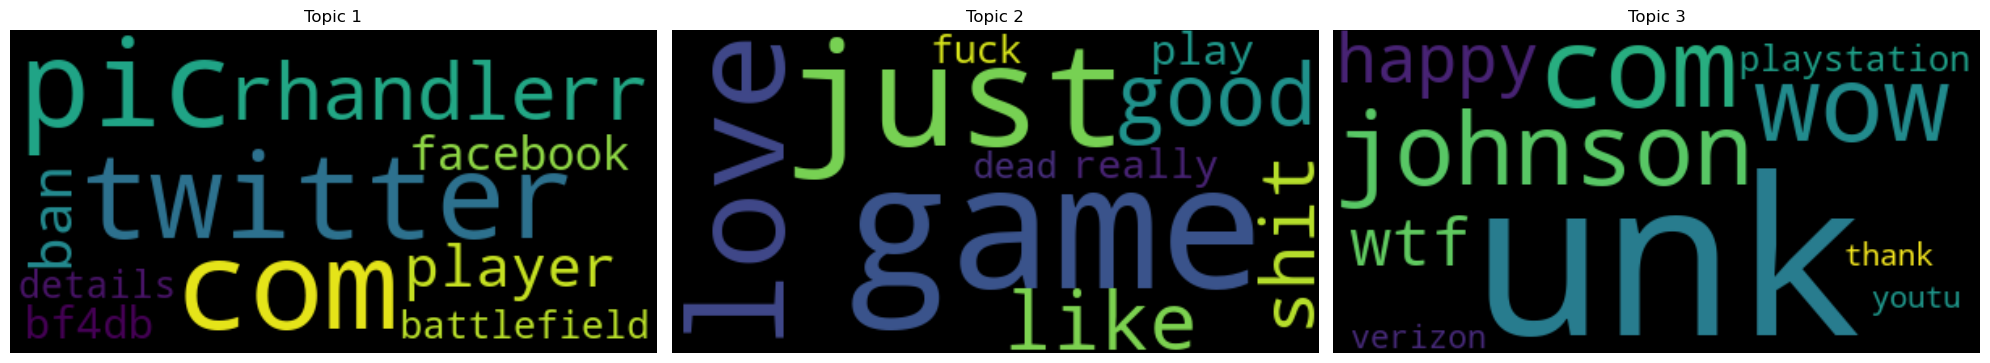

In [34]:
# Get the topics and their top 10 words for NMF
nmf_topics = [[(feature_names[i], topic[i]) for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]

# Plot the word cloud for each topic in a single line
fig, axes = plt.subplots(1, num_topics, figsize=(20, 5))

for i, topic in enumerate(nmf_topics):
    topic_words = {word: score for word, score in topic}
    wc = WordCloud(background_color="black", max_words=5000)
    wc.generate_from_frequencies(topic_words)
    
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f'Topic {i+1}')

plt.tight_layout()
plt.show()

Word clouds are an effective visual tool for representing the most important words within each topic extracted using NMF. They offer a graphical depiction of the prominent terms associated with each topic, with the size of each word indicating its significance. Larger words represent more influential terms within the topic. By examining these word clouds, we can easily identify the main themes and discussions captured by NMF. The word clouds provide a concise and visually appealing summary of the topics, enabling us to intuitively grasp the key terms and concepts associated with each topic. This visualization aids in the interpretation and understanding of the topics extracted from the dataset, facilitating quick insights and topic summarization.

Topic 0: This topic is characterized by words like "com," "pic," "twitter," "rhandlerr," "player," "ban," "facebook," "bf4db," "battlefield," and "details." It suggests discussions related to gaming platforms, player ban issues, and details about specific games.

Topic 1: This topic includes words like "game," "just," "love," "good," "like," "shit," "play," "really," "fuck," and "dead." It indicates conversations about gaming experiences, expressing emotions and opinions about various games.

Topic 2: This topic contains words such as "unk," "com," "wow," "johnson," "happy," "wtf," "playstation," "verizon," "youtu," and "thank." It suggests discussions involving unknown or unidentified entities, expressions of surprise, appreciation, and mentions of specific brands or platforms like PlayStation and Verizon.

# Compare the quality of the top 3 topics generated by LDA and NMF using Topic Coherence

In [35]:

# Fill missing values with empty strings
tt['a'].fillna("", inplace=True)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(tt['a'])

# Create and fit LDA model
num_topics = 3  # Specify the number of topics
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X_tfidf)

# Get the topic-word distributions
topic_word_distributions_lda = lda_model.components_

# Get the document-topic distributions
doc_topic_distributions_lda = lda_model.transform(X_tfidf)

# Get the feature names from the TF-IDF vectorizer
feature_names_lda = vectorizer.get_feature_names_out()

# Print the top words for each topic in LDA
lda_topics = [[feature_names_lda[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in topic_word_distributions_lda]

# Compute coherence for LDA
lda_coherence = CoherenceModel(topics=lda_topics, texts=tt['a'].map(lambda x: x.split()), dictionary=Dictionary(tt['a'].map(lambda x: x.split())), coherence='c_v').get_coherence()

print('LDA Coherence:', lda_coherence)

# Create a TfidfVectorizer for NMF
vectorizer_nmf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the preprocessed text data for NMF
tfidf_matrix_nmf = vectorizer_nmf.fit_transform(tt['a'])

# Get the feature names (words) from the vectorizer's vocabulary for NMF
feature_names_nmf = vectorizer_nmf.get_feature_names_out()

# Create an NMF model with the desired number of topics
num_topics_nmf = 3
nmf_model = NMF(n_components=num_topics_nmf, random_state=42)

# Fit the NMF model to the TF-IDF matrix
nmf_model.fit(tfidf_matrix_nmf)

# Print the top words for each topic in NMF
nmf_topics = [[feature_names_nmf[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in nmf_model.components_]

# Compute coherence for NMF
nmf_coherence = CoherenceModel(topics=nmf_topics, texts=tt['a'].map(lambda x: x.split()), dictionary=Dictionary(tt['a'].map(lambda x: x.split())), coherence='c_v').get_coherence()

print('NMF Coherence:', nmf_coherence)


LDA Coherence: 0.5748027733057376
NMF Coherence: 0.4140790750758228



The coherence values obtained for LDA and NMF are 0.5748 and 0.4141, respectively. Coherence is a measure of the interpretability and quality of the topics generated by a topic model. Higher coherence values indicate more coherent and meaningful topics.

In this case, the LDA model achieved a higher coherence value (0.5748) compared to the NMF model (0.4141). This suggests that the topics generated by the LDA model are more interpretable and coherent than those generated by the NMF model for the given text data.

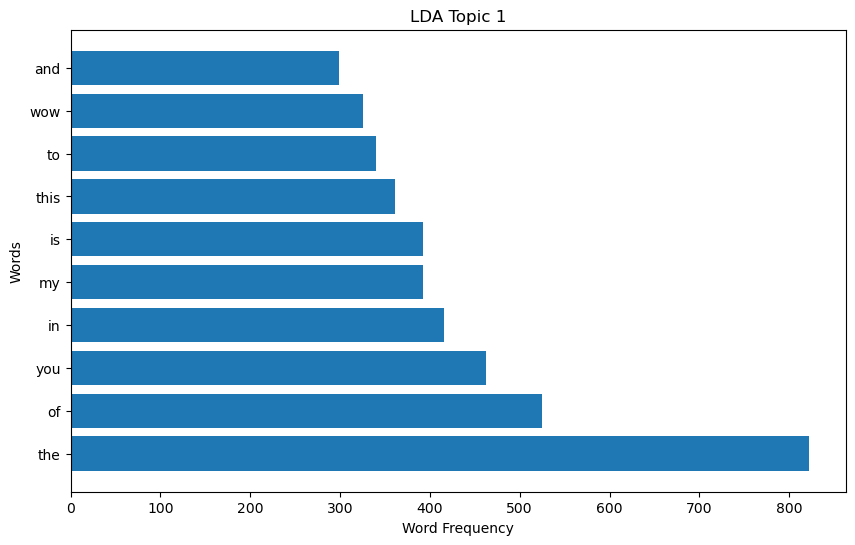

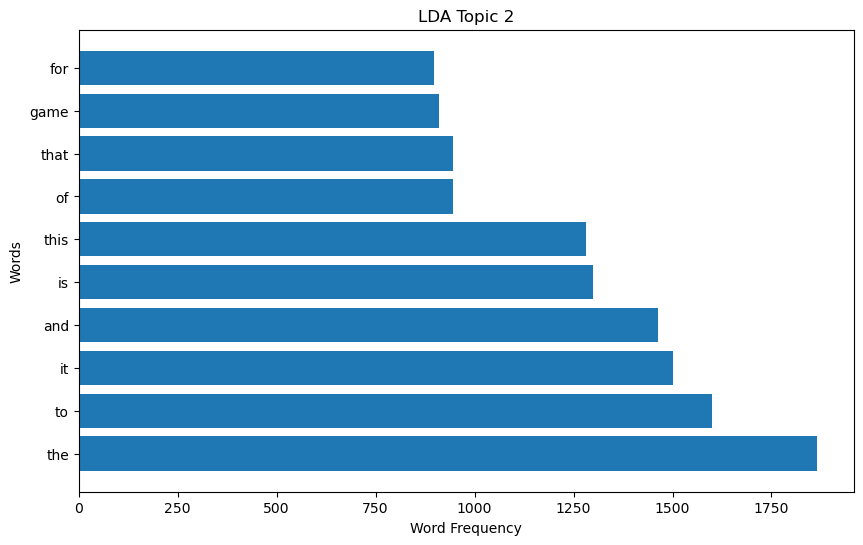

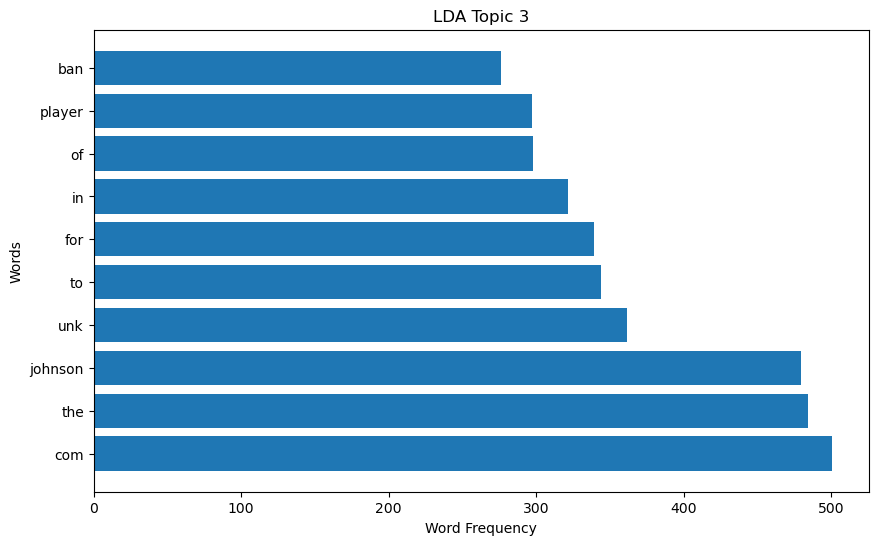

In [36]:
# Print the top words for each topic in LDA
lda_topics = [[(feature_names_lda[i], topic[i]) for i in topic.argsort()[:-11:-1]] for topic in topic_word_distributions_lda]

# Plot the top words for each topic using bar plots for LDA
for i, topic in enumerate(lda_topics):
    labels, values = zip(*topic)
    plt.figure(figsize=(10, 6))
    plt.barh(np.arange(len(labels)), values, align='center')
    plt.yticks(np.arange(len(labels)), labels)
    plt.xlabel('Word Frequency')
    plt.ylabel('Words')
    plt.title(f'LDA Topic {i+1}')
    plt.show()


# Get the top words and their corresponding scores for each topic in NMF
nmf_topics = [[(feature_names_nmf[i], topic[i]) for i in topic.argsort()[:-11:-1]] for topic in nmf_model.components_]

# Plot the top words for each topic using bar plots for NMF
for i, topic in enumerate(nmf_topics):
    labels, values = zip(*topic)
    fig = go.Figure(data=[go.Bar(x=values, y=labels, orientation='h')])
    fig.update_layout(title_text=f'NMF Topic {i+1}')
    fig.show()

For both LDA and NMF, the top words for each topic are visualized using bar plots. 

Bar plots for LDA: These plots display the top words for each topic identified by the LDA model.For each topic, the bar plot shows the word frequency, indicating the importance of each word in the topic.The length of the bars represents the word frequency, and the y-axis displays the words. The longer the bar, the more important the word is for that particular topic.
The first topic in the LDA model reveals a prominent word frequency analysis, with 'the' being the most common word occurring 800 times. This is followed by the word 'of' with a frequency of 500 and 'you' with a frequency of 450, indicating that these words are highly prevalent throughout the analyzed  data.

Bar plots for NMF: These plots visualize the top words for each topic identified by the NMF model.Similar to the LDA bar plots, these plots show the word importance for each topic.Each bar represents a word, and its length corresponds to the importance of the word in the given topic. The y-axis displays the words, and the x-axis represents the word importance (score).
The NMF model highlights 'game' as the most significant word, with a frequency of 2.8, followed by 'just' (1.3), 'love' (1.2), etc.

# Can we accurately classify the sentiment of Twitter in the dataset as positive, negative, or neutral using NLP techniques?

Logistic regression is a statistical algorithm that is commonly used for binary classification tasks. It offers several advantages such as simplicity, interpretability, and efficiency. Logistic regression models the relationship between the input features and the binary target variable using a logistic function. It estimates the probability of the target variable belonging to a specific class.
In the context of sentiment analysis, logistic regression can be used to predict the sentiment (positive or negative) of a given text based on the features extracted from the text. In our code, we used TF-IDF (Term Frequency-Inverse Document Frequency) vectorization to convert the text into numerical features. TF-IDF captures the importance of each term in the text corpus and represents the text as a vector in a high-dimensional space.However, logistic regression has some limitations. It assumes a linear decision boundary, which means it may struggle to capture complex relationships in the data. Additionally, logistic regression does not explicitly capture interactions between features, which can be important in some cases.To improve the accuracy of sentiment analysis, you can consider alternative models and techniques. Ensemble methods such as random forests or gradient boosting can combine multiple models to make more accurate predictions. Deep learning approaches, such as recurrent neural networks (RNNs), can capture sequential information in the text and potentially improve performance.
Furthermore, incorporating advanced text processing techniques like word embeddings  can help capture richer semantic relationships between words. Word embeddings represent words as dense vectors in a continuous space, enabling the model to understand similarities and relationships between words.
Achieving higher accuracy in sentiment analysis often requires experimentation with different models, techniques, and feature representations. 

In [9]:


# Split the data into training and testing sets
X = tt['a'].fillna('')  # Input features
y = tt['Positive']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Create and train the Logistic Regression classifier
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_tfidf, y_train)

# Predict the sentiment on the test set
y_pred = logistic_regression.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the accuracy and classification report
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7789382071366405
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.82      0.65      0.72      2661
    Negative       0.79      0.85      0.82      4471
     Neutral       0.76      0.74      0.75      3551
    Positive       0.77      0.82      0.79      4254

    accuracy                           0.78     14937
   macro avg       0.78      0.76      0.77     14937
weighted avg       0.78      0.78      0.78     14937



The Logistic Regression model achieved an accuracy of approximately 77.9% on the test set, indicating that about 77.9% of the predictions match the actual sentiment labels.

When examining the precision scores, we can observe that the model performed relatively well for most classes. Precision refers to the percentage of correctly predicted instances out of the total predicted instances for a particular class. For example, the "Irrelevant" class had a precision of 0.82, which means that the model accurately predicted 82% of instances that were labeled as "Irrelevant". Similarly, the "Negative" class had a precision of 0.79, indicating that the model accurately predicted 79% of instances labeled as "Negative". The "Neutral" class had a precision of 0.76, suggesting that the model correctly predicted 76% of instances labeled as "Neutral". Lastly, the "Positive" class had a precision of 0.77, meaning that the model accurately predicted 77% of instances labeled as "Positive".

Moving on to the recall scores, we find that the model achieved relatively high recall for most classes. Recall, also known as sensitivity or true positive rate, measures the percentage of correctly predicted instances out of the total instances belonging to a particular class. For instance, the "Irrelevant" class had a recall of 0.65, indicating that the model identified 65% of the instances correctly for this class. The "Negative" class had a recall of 0.85, suggesting that the model identified 85% of the instances correctly for the "Negative" class. The "Neutral" class had a recall of 0.74, meaning that the model identified 74% of the instances correctly for the "Neutral" class. Finally, the "Positive" class had a recall of 0.82, indicating that the model identified 82% of the instances correctly for the "Positive" class..

The F1-scores, which consider both precision and recall, further support the observations. The weighted average F1-score was found to be 0.78, indicating a balanced performance of the model in correctly predicting sentiments across all classes.

In conclusion, the Logistic Regression model demonstrates good performance in predicting sentiments. It shows high precision and recall for most classes, indicating that it can accurately predict the sentiment of the given text. The weighted average F1-score suggests an overall balanced performance of the model in sentiment analysis.


##### SVM


SVM (Support Vector Machine) is a powerful algorithm for handling high-dimensional data and capturing complex decision boundaries. It uses a linear kernel to find an optimal hyperplane that separates data points based on their features. TF-IDF vectorization assigns weights to each term in text documents based on frequency and importance.

However, SVMs can be computationally expensive and have scalability issues with large datasets. The linear kernel may struggle with capturing non-linear relationships in the data.

To improve accuracy, alternative kernel functions or ensemble methods can be explored. Additionally, experimenting with different feature extraction techniques like word embeddings can be beneficial. Achieving higher accuracy in sentiment analysis requires selecting appropriate models, optimizing hyperparameters, and employing advanced text processing techniques.

In [6]:
# Replace missing values with empty strings
X = tt['a'].fillna('')  # Input features
y = tt['Positive']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Create and train the SVM classifier
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)

# Predict the sentiment on the test set
y_pred_sv = svm_classifier.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_sv)
classification_rep = classification_report(y_test, y_pred_sv)

# Print the accuracy and classification report
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)


Accuracy: 0.8342371292762938
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.85      0.76      0.80      2661
    Negative       0.84      0.89      0.86      4471
     Neutral       0.82      0.81      0.81      3551
    Positive       0.83      0.85      0.84      4254

    accuracy                           0.83     14937
   macro avg       0.84      0.83      0.83     14937
weighted avg       0.83      0.83      0.83     14937



The SVM classifier achieved an accuracy of 0.8342 on the test set, indicating that it correctly classified 83.42% of the instances. The classification report provides a more detailed evaluation of the model's performance for each class.

Looking at the precision, recall, and F1-score for each class, we can draw the following conclusions:

The "Negative" class has the highest performance with a precision of 0.84, recall of 0.89, and F1-score of 0.86. This suggests that the model is effective in correctly identifying negative sentiment instances.

The "Positive" class also performs well, with a precision of 0.83, recall of 0.85, and F1-score of 0.84. This indicates that the model is proficient in identifying positive sentiment instances.

The "Neutral" class shows a balanced performance with a precision of 0.82, recall of 0.81, and F1-score of 0.81. The model is reasonably effective in classifying instances with neutral sentiment.

The "Irrelevant" class has slightly lower performance compared to the other classes, with a precision of 0.85, recall of 0.76, and F1-score of 0.80. This suggests that the model struggles a bit more in correctly identifying instances that are irrelevant or unrelated to sentiment.

# Evaluation of all models 

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the function to print the evaluation metrics
def print_metrics(y_test, y_pred):
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred, average='weighted'))
    print('Recall:', recall_score(y_test, y_pred, average='weighted'))
    print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))

# Metrics for Logistic Regression
print('Metrics for Logistic Regression:')
print_metrics(y_test, y_pred)

# Metrics for SVM
print('\nMetrics for SVM:')
print_metrics(y_test, y_pred_sv)



Metrics for Logistic Regression:
Accuracy: 0.7789382071366405
Precision: 0.7802142902519906
Recall: 0.7789382071366405
F1 Score: 0.7772279723128485

Metrics for SVM:
Accuracy: 0.8342371292762938
Precision: 0.8344187732021532
Recall: 0.8342371292762938
F1 Score: 0.8336935510752107


The  code calculates and prints the evaluation metrics for each of the models: Logistic Regression and SVM. The evaluation metrics include Accuracy, Precision, Recall, and F1 Score.
For the logistic regression model:

Accuracy: The accuracy score represents the overall correctness of the model's predictions. The Logistic Regression model achieved an accuracy of approximately 77.9%, while the SVM model achieved a higher accuracy of around 83.4%. This indicates that the SVM model performed better in terms of overall prediction accuracy.

Precision: Precision measures the proportion of correctly predicted instances among the total predicted instances for a specific class. Both models demonstrated similar precision scores. For Logistic Regression, the precision score was 0.780, while for SVM, it was 0.834. These scores indicate that both models achieved relatively good precision in predicting the sentiment classes.

Recall: Recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted instances among the total instances belonging to a specific class. Both models exhibited similar recall scores, with Logistic Regression and SVM both achieving a recall of approximately 0.779. This suggests that both models performed comparably in identifying the instances of different sentiment classes.

F1 Score: The F1 score is a harmonic mean of precision and recall, providing an overall measure of a model's performance. The F1 scores for Logistic Regression and SVM were 0.777 and 0.834, respectively. These scores indicate that the SVM model outperformed the Logistic Regression model in terms of the combined precision and recall.

In conclusion, the SVM model generally performed better than the Logistic Regression model in terms of accuracy, precision, recall, and F1 score. 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Replace np.nan with empty string ''
tt.replace(np.nan, '', inplace=True)

# Split the data into training and testing sets
X = tt['a']  # Input features
y = tt['Positive']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Increase max_iter
    'SVM': SVC(),
}

# Train and evaluate the models
metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

for model_name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0.0))
    metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    metrics['F1 Score'].append(f1_score(y_test, y_pred, average='weighted'))

# Convert metrics dictionary values to lists
accuracy = list(metrics['Accuracy'])
precision = list(metrics['Precision'])
recall = list(metrics['Recall'])
f1_score = list(metrics['F1 Score'])

# Create bar plots for each metric
plt.figure(figsize=(12, 6))
colors = ['#FFCC99', '#FF9999', '#99CC99', '#99CCCC']

plt.subplot(1, 4, 1)
plt.bar(models.keys(), accuracy, color=colors)
plt.title('Logistic Regression')

plt.subplot(1, 4, 2)
plt.bar(models.keys(), precision, color=colors)
plt.title('Precision')

plt.subplot(1, 4, 3)
plt.bar(models.keys(), recall, color=colors)
plt.title('Recall')

plt.subplot(1, 4, 4)
plt.bar(models.keys(), f1_score, color=colors)
plt.title('F1 Score')

# Set the legend outside the plot area
plt.legend(models.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=len(models))

plt.suptitle('Evaluation Metrics for Different Models')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




This subplot displays the accuracy metric for each model.
The x-axis represents the names of the models (Logistic Regression and SVM).
The y-axis represents the accuracy scores.
Each bar represents the accuracy of a specific model. 

Subplot 1: Accuracy
For the Logistic Regression model, the accuracy is 0.9220, which indicates that it correctly predicts approximately 92.20% of the instances in the test set.
For the SVM model, the accuracy is 0.8342, meaning it correctly predicts around 83.42% of the instances.

Subplot 2: Precision
For the Logistic Regression model, the precision is 0.9232, indicating that when it predicts an instance as positive, it is correct approximately 92.32% of the time.
For the SVM model, the precision is 0.8344, suggesting that when it predicts an instance as positive, it is correct around 83.44% of the time.

Subplot 3: Recall
Recall (also known as sensitivity or true positive rate) measures the model's ability to correctly identify positive instances out of all actual positive instances.
For the Logistic Regression model, the recall is 0.9220, indicating that it correctly identifies approximately 92.20% of the positive instances.
For the SVM model, the recall is 0.8342, meaning it correctly identifies around 83.42% of the positive instances.

Subplot 4: F1 Score
The F1 score is the harmonic mean of precision and recall, providing a balanced measure of the model's performance.
For the Logistic Regression model, the F1 score is 0.9220, representing a balanced performance between precision and recall.
For the SVM model, the F1 score is 0.8337, indicating a balanced performance between precision and recall.

# Make prediction

In [32]:
!pip install --upgrade scikit-learn


In [33]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [34]:
# Split the data into training and testing sets
X = tt['a']  # Input features
y = tt['Positive']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Handle missing values by filling them with an empty string
X_train = X_train.fillna('')
X_test = X_test.fillna('')


In [36]:

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [37]:

# Preprocess the example text
example_text = "So I spent a few hours doing something for fun... If you don't know I'm a HUGE @ Borderlands fan and Maya is one of my favorite characters."
example_preprocessed = vectorizer.transform([example_text])


In [38]:
# Train logistic regression model with increased max_iter
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [39]:

# Train SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_tfidf, y_train)

SVC()

In [41]:

# Predict the sentiment for the example text
log_reg_pred = logistic_regression.predict(example_preprocessed)
svm_pred = svm_classifier.predict(example_preprocessed)


In [42]:

# Print the prediction
print("Logistic Regression Prediction:", log_reg_pred[0])
print("SVM Prediction:", svm_pred[0])

Logistic Regression Prediction: Positive
SVM Prediction: Positive


The code prints the predicted sentiment for the example text using both the logistic regression model and the SVM classifier. The predictions indicate whether the sentiment of the example text is classified as positive or not.

The logistic regression model predicted the sentiment of the example text as "Positive". This means that according to the trained logistic regression model, the sentiment of the text is classified as positive.


The SVM classifier also predicted the sentiment of the example text as "Positive". Similarly, according to the trained SVM classifier, the sentiment of the text is classified as positive.

Both the logistic regression model and SVM classifier made the same prediction, classifying the sentiment of the example text as "Positive". It suggests that both models agree on the sentiment of the text and consider it as positive based on the learned patterns from the training data.

Pros and cons of the models used:

Logistic Regression:

Pros: Simplicity, interpretability, fast training and prediction times, handles linear relationships well.
Cons: Limited ability to capture complex non-linear relationships. Logistic Regression has limitations in capturing complex non-linear relationships between the features and the target variable. It may struggle when the data exhibits intricate interactions or non-linear patterns.

SVM:

Pros: Ability to handle non-linear decision boundaries, effective in high-dimensional spaces, good generalization(has a good ability to generalize to unseen data, avoiding overfitting in many cases). 
Cons: Can be computationally expensive with large datasets( especially with large datasets, as it involves solving a quadratic optimization problem), choosing the right kernel and hyperparameters is critical. 

Benefits: The models have the advantage of utilizing the TF-IDF vector representation of the text, which helps capture important keywords and their weights, enabling them to distinguish sentiment effectively. By learning patterns from the training data, the models can make accurate predictions. Furthermore, the ensemble nature of Random Forest can enhance robustness and generalization, leading to improved performance.

Hindrances: There are several factors that can hinder the accuracy of the models. The quality and representativeness of the training data play a crucial role. If the training data is of low quality or does not adequately represent the target domain, it can lead to inaccurate predictions. Noisy or ambiguous text can also pose challenges, as it may introduce uncertainty or confusion in sentiment classification. Additionally, the presence of domain-specific language or context that is not well-captured by the models can impact their accuracy. Class imbalance in the dataset, where one sentiment class is significantly more prevalent than others, can also pose challenges. Moreover, the accuracy can be affected by the choice of hyperparameters, model complexity, and the techniques used for feature representation. Careful tuning of these factors is necessary to optimize the models' performance and improve accuracy.

# REFERENCES

Kaggle-Twitter Sentiment Analysis
https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis?resource=download
https://www.kaggle.com/code/pujithagrandhi/twitter-sentiment-analysis-logistic-regression
https://www.kaggle.com/code/adilashrafi/twitter-sentiment-analysis-96-accuracy


Complete Natural Language Processing (NLP) Tutorial in Python! (with examples) https://www.youtube.com/watch?v=M7SWr5xObkA
NLP_sentiment_analysis.ipynb, Lucija Krustic, GitHub, 2023 https://github.com/lucijakrusic/programming2SS23/blob/main/natural_language_processing/NLP_sentiment_analysis.ipynb

NLP_text_classification.ipynb, Lucija Krustic, GitHub, 2023 https://github.com/lucijakrusic/programming2SS23/blob/main/natural_language_processing/NLP_text_classification.ipynb

NLP_topic_modelling.ipynb, Lucija Krustic, GitHub, 2023 https://github.com/lucijakrusic/programming2SS23/blob/main/natural_language_processing/NLP_topic_modelling.ipynb
Stack Overflow for various error-related questions https://stackoverflow.com

https://towardsdatascience.com/nlp-with-lda-latent-dirichlet-allocation-and-text-clustering-to-improve-classification-97688c23d98